<a href="https://colab.research.google.com/github/fjadidi2001/Denoise/blob/main/DenoiseJun1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Enhanced Lightweight Image Denoising Networks with Adaptive Feature Fusion
# Project: Image Denoising using UNet with Attention on BSR Dataset

import os
import glob
import cv2
import numpy as np
import h5py
import random
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as udata
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from torch.nn.modules.loss import _Loss
import time
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import torchvision.transforms as transforms
from PIL import Image

# ===============================================================================
# Cell 1: Setup and Configuration
# ===============================================================================

# Set base directory
base_dir = '/content/drive/MyDrive/SSNet'
os.makedirs(f'{base_dir}/data', exist_ok=True)
os.makedirs(f'{base_dir}/output', exist_ok=True)
os.makedirs(f'{base_dir}/saved_models', exist_ok=True)

# Set random seeds for reproducibility
def seed_torch(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_torch()

print("Project Setup Complete!")
print(f"Base directory: {base_dir}")
print(f"CUDA available: {torch.cuda.is_available()}")


Project Setup Complete!
Base directory: /content/drive/MyDrive/SSNet
CUDA available: True


Dataset loaded successfully
Processing BSR dataset...
Found 200 training, 100 validation, 200 test images
Processing training image 1/200
Processing training image 51/200
Processing training image 101/200
Processing training image 151/200

Dataset Statistics:
       Subset  Images  Patches  HDF5 Size (MB)
0       Train     200     2400     1800.876221
1  Validation     100      100      176.735031
2        Test     200      200      353.470795


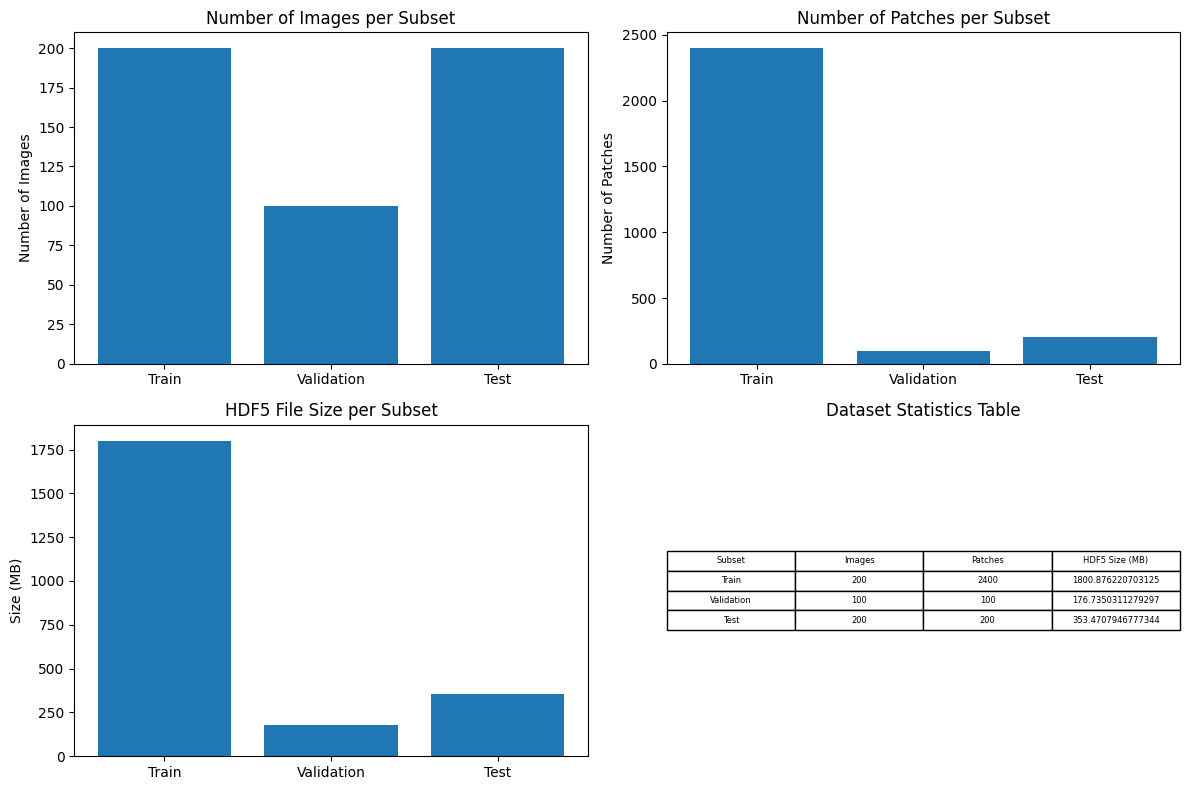

Testing dataset and noise functions...
Sample batch shape: torch.Size([4, 3, 256, 256])
Noisy batch shape: torch.Size([4, 3, 256, 256])
Noise statistics - Mean: -0.000012, Std: 0.067261


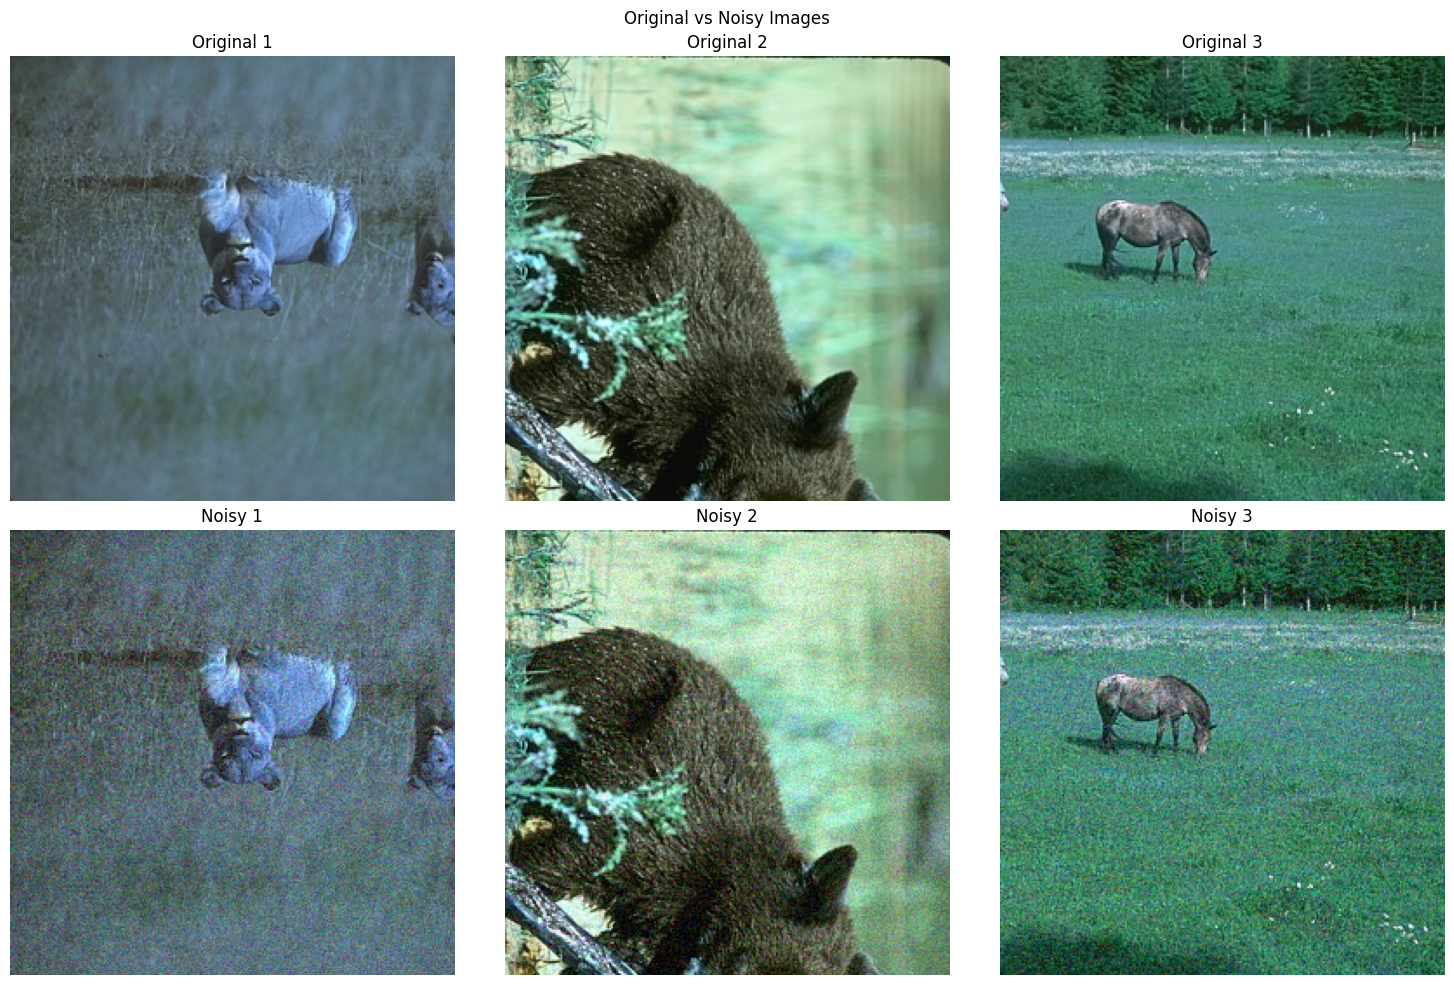

Dataset and noise functions working correctly!


In [ ]:
# ===============================================================================
# Cell 2: Download and Preprocess BSR Dataset
# ===============================================================================

def normalize(data):
    """Normalize data to [0, 1] range"""
    return data / 255.0

def Im2Patch(img, win, stride=1):
    """Extract patches from image"""
    k = 0
    endc = img.shape[0]
    endw = img.shape[1]
    endh = img.shape[2]
    patch = img[:, 0:endw-win+0+1:stride, 0:endh-win+0+1:stride]
    TotalPatNum = patch.shape[1] * patch.shape[2]
    Y = np.zeros([endc, win*win, TotalPatNum], np.float32)
    for i in range(win):
        for j in range(win):
            patch = img[:, i:endw-win+i+1:stride, j:endh-win+j+1:stride]
            Y[:, k, :] = np.array(patch[:]).reshape(endc, TotalPatNum)
            k = k + 1
    return Y.reshape([endc, win, win, TotalPatNum])

def data_augmentation(image, mode):
    """Apply data augmentation"""
    out = np.transpose(image, (1, 2, 0))
    if mode == 0:
        out = out
    elif mode == 1:
        out = np.flipud(out)
    elif mode == 2:
        out = np.rot90(out)
    elif mode == 3:
        out = np.rot90(out)
        out = np.flipud(out)
    elif mode == 4:
        out = np.rot90(out, k=2)
    elif mode == 5:
        out = np.rot90(out, k=2)
        out = np.flipud(out)
    elif mode == 6:
        out = np.rot90(out, k=3)
    elif mode == 7:
        out = np.rot90(out, k=3)
        out = np.flipud(out)
    return np.transpose(out, (2, 0, 1))

# Download BSR dataset
try:
    if not os.path.exists('BSR_bsds500.tgz'):
        os.system('wget https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz')
    if not os.path.exists('BSR'):
        os.system('tar xzf BSR_bsds500.tgz')
    print("Dataset loaded successfully")
except Exception as e:
    print(f"Error loading dataset: {e}")

def prepare_data(data_path, bsr_root, patch_size=256, stride=128, aug_times=1):
    """Prepare BSR dataset for training"""
    print('Processing BSR dataset...')
    scales = [1, 0.9, 0.8, 0.7]

    # Collect train, val, test images
    train_files = glob.glob(os.path.join(bsr_root, 'BSR/BSDS500/data/images/train', '*.jpg'))
    val_files = glob.glob(os.path.join(bsr_root, 'BSR/BSDS500/data/images/val', '*.jpg'))
    test_files = glob.glob(os.path.join(bsr_root, 'BSR/BSDS500/data/images/test', '*.jpg'))

    print(f"Found {len(train_files)} training, {len(val_files)} validation, {len(test_files)} test images")

    # Process training data
    h5f = h5py.File(os.path.join(data_path, 'train_clean.h5'), 'w')
    train_num = 0
    for i, file_path in enumerate(train_files):
        if i % 50 == 0:
            print(f"Processing training image {i+1}/{len(train_files)}")

        img = cv2.imread(file_path)
        if img is None:
            continue
        h, w, c = img.shape

        for k in range(len(scales)):
            if int(h * scales[k]) < patch_size or int(w * scales[k]) < patch_size:
                continue
            Img = cv2.resize(img, (int(w * scales[k]), int(h * scales[k])), interpolation=cv2.INTER_CUBIC)
            Img = np.transpose(Img, (2, 0, 1))
            Img = np.float32(normalize(Img))
            patches = Im2Patch(Img, win=patch_size, stride=stride)

            for n in range(patches.shape[3]):
                data = patches[:, :, :, n].copy()
                h5f.create_dataset(str(train_num), data=data)
                train_num += 1

                # Data augmentation
                for m in range(aug_times - 1):
                    data_aug = data_augmentation(data, np.random.randint(1, 8))
                    h5f.create_dataset(str(train_num) + "_aug_%d" % (m + 1), data=data_aug)
                    train_num += 1
    h5f.close()

    # Process validation data
    h5f = h5py.File(os.path.join(data_path, 'val_clean.h5'), 'w')
    val_num = 0
    for i, file_path in enumerate(val_files):
        img = cv2.imread(file_path)
        if img is None:
            continue
        img = np.transpose(img, (2, 0, 1))
        img = np.float32(normalize(img))
        h5f.create_dataset(str(val_num), data=img)
        val_num += 1
    h5f.close()

    # Process test data
    h5f = h5py.File(os.path.join(data_path, 'test_clean.h5'), 'w')
    test_num = 0
    for i, file_path in enumerate(test_files):
        img = cv2.imread(file_path)
        if img is None:
            continue
        img = np.transpose(img, (2, 0, 1))
        img = np.float32(normalize(img))
        h5f.create_dataset(str(test_num), data=img)
        test_num += 1
    h5f.close()

    # Collect statistics
    stats = {
        'Subset': ['Train', 'Validation', 'Test'],
        'Images': [len(train_files), len(val_files), len(test_files)],
        'Patches': [train_num, val_num, test_num],
        'HDF5 Size (MB)': [
            os.path.getsize(f'{data_path}/train_clean.h5') / 1024**2,
            os.path.getsize(f'{data_path}/val_clean.h5') / 1024**2,
            os.path.getsize(f'{data_path}/test_clean.h5') / 1024**2
        ]
    }
    df = pd.DataFrame(stats)
    print("\nDataset Statistics:")
    print(df)

    # Plot statistics
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.bar(df['Subset'], df['Images'])
    plt.title('Number of Images per Subset')
    plt.ylabel('Number of Images')

    plt.subplot(2, 2, 2)
    plt.bar(df['Subset'], df['Patches'])
    plt.title('Number of Patches per Subset')
    plt.ylabel('Number of Patches')

    plt.subplot(2, 2, 3)
    plt.bar(df['Subset'], df['HDF5 Size (MB)'])
    plt.title('HDF5 File Size per Subset')
    plt.ylabel('Size (MB)')

    plt.subplot(2, 2, 4)
    plt.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')
    plt.axis('off')
    plt.title("Dataset Statistics Table")

    plt.tight_layout()
    plt.savefig(f'{base_dir}/output/dataset_statistics.png', dpi=300, bbox_inches='tight')
    plt.show()

    return df

# Prepare the dataset
dataset_stats = prepare_data(f'{base_dir}/data', '.', patch_size=256, stride=128, aug_times=2)

# ===============================================================================
# Cell 3: Define Dataset Class and Noise Functions
# ===============================================================================

class BSRDataset(Dataset):
    """BSR Dataset class for loading HDF5 data"""
    def __init__(self, data_path, train=True):
        super(BSRDataset, self).__init__()
        self.train = train
        filename = 'train_clean.h5' if train else 'val_clean.h5'
        self.h5_path = os.path.join(data_path, filename)

        with h5py.File(self.h5_path, 'r') as h5f:
            self.keys = list(h5f.keys())
        random.shuffle(self.keys)

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, index):
        with h5py.File(self.h5_path, 'r') as h5f:
            key = self.keys[index]
            data = np.array(h5f[key])
        return torch.Tensor(data)

def add_gaussian_noise(clean_img, noise_level_range=(0, 55)):
    """Add Gaussian noise to clean images"""
    noise = torch.zeros_like(clean_img)
    batch_size = clean_img.size(0)

    for i in range(batch_size):
        noise_level = np.random.uniform(noise_level_range[0], noise_level_range[1])
        noise[i] = torch.randn_like(clean_img[i]) * (noise_level / 255.0)

    noisy_img = clean_img + noise
    return torch.clamp(noisy_img, 0., 1.), noise

# Test dataset class and noise function
print("Testing dataset and noise functions...")
try:
    # Create small test dataset
    test_dataset = BSRDataset(f'{base_dir}/data', train=True)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

    # Get sample batch
    sample_batch = next(iter(test_loader))
    print(f"Sample batch shape: {sample_batch.shape}")

    # Test noise addition
    noisy_batch, noise = add_gaussian_noise(sample_batch, (15, 25))
    print(f"Noisy batch shape: {noisy_batch.shape}")
    print(f"Noise statistics - Mean: {noise.mean():.6f}, Std: {noise.std():.6f}")

    # Visualize noise addition
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    for i in range(3):
        # Original
        orig_img = np.transpose(sample_batch[i].numpy(), (1, 2, 0))
        axes[0, i].imshow(orig_img)
        axes[0, i].set_title(f'Original {i+1}')
        axes[0, i].axis('off')

        # Noisy
        noisy_img = np.transpose(noisy_batch[i].numpy(), (1, 2, 0))
        axes[1, i].imshow(noisy_img)
        axes[1, i].set_title(f'Noisy {i+1}')
        axes[1, i].axis('off')

    plt.suptitle('Original vs Noisy Images')
    plt.tight_layout()
    plt.savefig(f'{base_dir}/output/noise_examples.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Dataset and noise functions working correctly!")

except Exception as e:
    print(f"Error testing dataset: {e}")

Model Architecture Analysis:
Total parameters: 4,333,179
Trainable parameters: 4,333,179

Model Architecture (First 15 layers):
      Layer Name                Description
0         enc1.0              Conv2d(3->48)
1         enc1.2             Conv2d(48->48)
2          pool1                  MaxPool2d
3         enc2.0             Conv2d(48->96)
4         enc2.2             Conv2d(96->96)
5          pool2                  MaxPool2d
6         enc3.0            Conv2d(96->192)
7         enc3.2           Conv2d(192->192)
8          pool3                  MaxPool2d
9   bottleneck.0           Conv2d(192->384)
10  bottleneck.2           Conv2d(384->384)
11       upconv3  ConvTranspose2d(384->192)
12        dec3.0           Conv2d(384->192)
13        dec3.2           Conv2d(192->192)
14       upconv2   ConvTranspose2d(192->96)


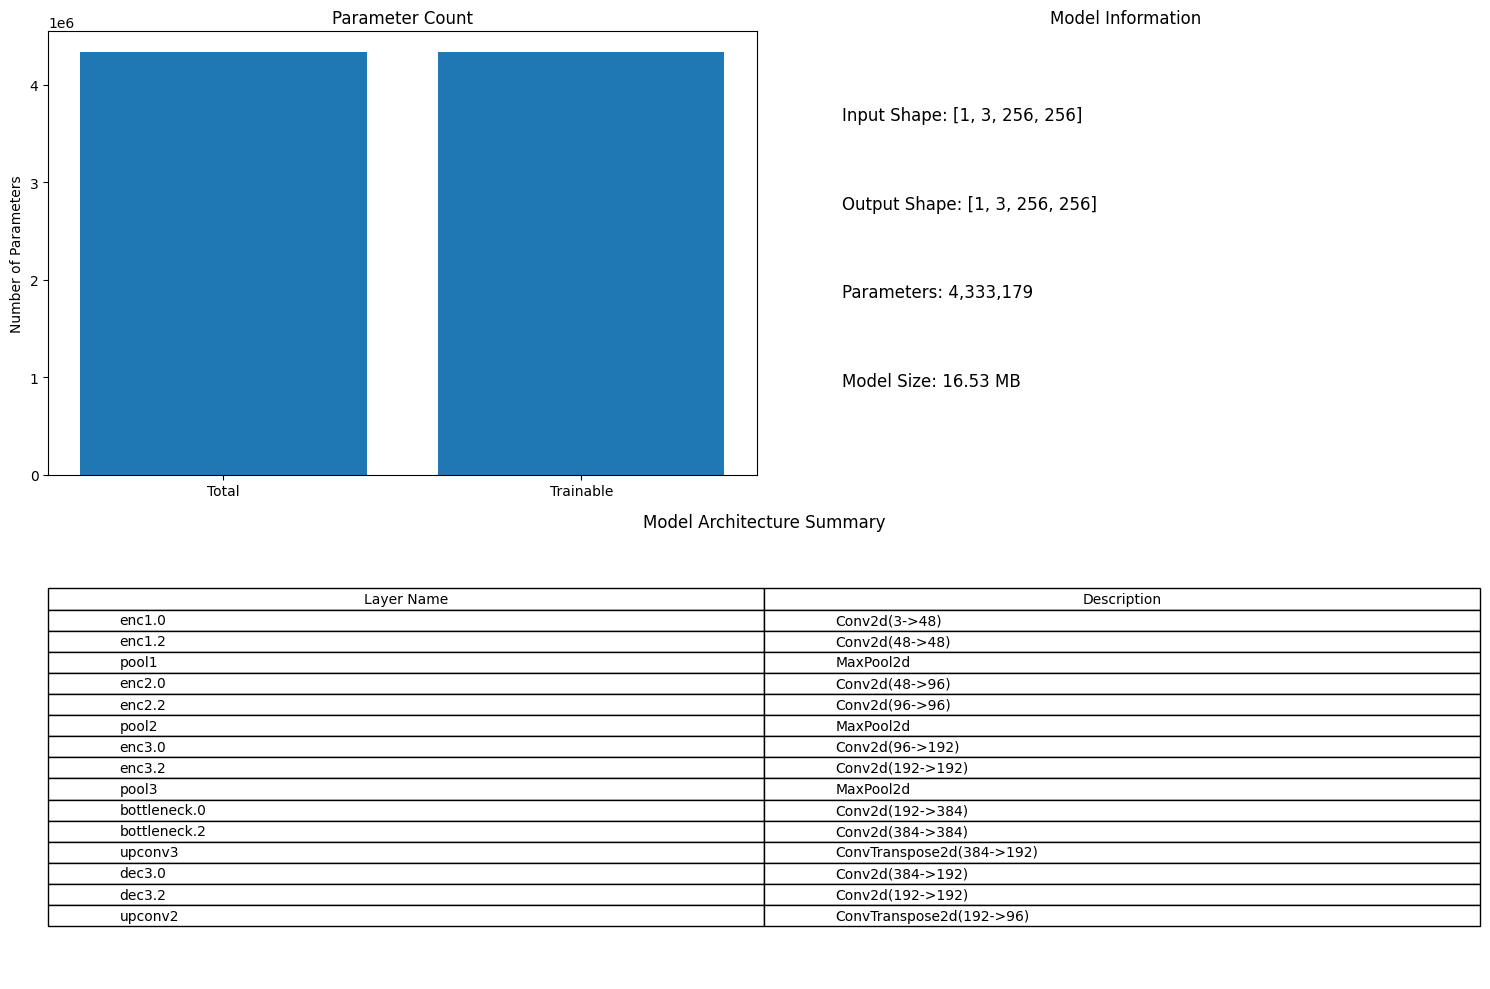

In [ ]:
# ===============================================================================
# Cell 4: Define Model Architecture
# ===============================================================================

class sum_squared_error(_Loss):
    """Sum Squared Error loss function"""
    def __init__(self, size_average=None, reduce=None, reduction='sum'):
        super(sum_squared_error, self).__init__(size_average, reduce, reduction)

    def forward(self, input, target):
        return torch.nn.functional.mse_loss(input, target, reduction='sum') / 2

class UNet_Denoiser(nn.Module):
    """Simplified UNet for image denoising"""
    def __init__(self, in_channels=3, out_channels=3):
        super(UNet_Denoiser, self).__init__()

        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 48, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(48, 48, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(48, 96, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = nn.Sequential(
            nn.Conv2d(96, 192, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(192, 384, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Decoder
        self.upconv3 = nn.ConvTranspose2d(384, 192, 2, stride=2)
        self.dec3 = nn.Sequential(
            nn.Conv2d(384, 192, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.upconv2 = nn.ConvTranspose2d(192, 96, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(192, 96, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.upconv1 = nn.ConvTranspose2d(96, 48, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(96, 48, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(48, 48, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Output layer
        self.final_conv = nn.Conv2d(48, out_channels, 1)

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(48, 24, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(24, 48, 1),
            nn.Sigmoid()
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e1_pooled = self.pool1(e1)

        e2 = self.enc2(e1_pooled)
        e2_pooled = self.pool2(e2)

        e3 = self.enc3(e2_pooled)
        e3_pooled = self.pool3(e3)

        # Bottleneck
        bottleneck = self.bottleneck(e3_pooled)

        # Decoder
        d3 = self.upconv3(bottleneck)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        # Apply attention
        attention_weights = self.attention(d1)
        d1 = d1 * attention_weights

        # Output
        output = self.final_conv(d1)

        return output

# Model analysis
model = UNet_Denoiser()
print("Model Architecture Analysis:")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Architecture summary
architecture_info = []
for name, module in model.named_modules():
    if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d, nn.MaxPool2d)):
        if hasattr(module, 'in_channels'):
            info = f"{module.__class__.__name__}({module.in_channels}->{module.out_channels})"
        else:
            info = f"{module.__class__.__name__}"
        architecture_info.append([name, info])

# Create architecture table
arch_df = pd.DataFrame(architecture_info[:15], columns=['Layer Name', 'Description'])  # Show first 15 layers
print("\nModel Architecture (First 15 layers):")
print(arch_df)

# Visualize architecture
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.bar(['Total', 'Trainable'], [total_params, trainable_params])
plt.title('Parameter Count')
plt.ylabel('Number of Parameters')

plt.subplot(2, 2, 2)
# Test forward pass with dummy input
dummy_input = torch.randn(1, 3, 256, 256)
with torch.no_grad():
    dummy_output = model(dummy_input)
plt.text(0.1, 0.8, f"Input Shape: {list(dummy_input.shape)}", transform=plt.gca().transAxes, fontsize=12)
plt.text(0.1, 0.6, f"Output Shape: {list(dummy_output.shape)}", transform=plt.gca().transAxes, fontsize=12)
plt.text(0.1, 0.4, f"Parameters: {total_params:,}", transform=plt.gca().transAxes, fontsize=12)
plt.text(0.1, 0.2, f"Model Size: {total_params * 4 / 1024**2:.2f} MB", transform=plt.gca().transAxes, fontsize=12)
plt.title('Model Information')
plt.axis('off')

plt.subplot(2, 1, 2)
plt.table(cellText=arch_df.values, colLabels=arch_df.columns, loc='center', cellLoc='left')
plt.axis('off')
plt.title("Model Architecture Summary")

plt.tight_layout()
plt.savefig(f'{base_dir}/output/model_architecture.png', dpi=300, bbox_inches='tight')
plt.show()